Model loaded from data\energy_forecast_model.pkl
Fetching PJM load data for MIDATL from 2024-03-22 to 2025-03-21...
Loading cached PJM data from data\pjm_MIDATL_2024-03-22_2025-03-21.csv
Fetching weather data for KPHL from 2024-03-22 to 2025-03-21...
Loading cached weather data from data\weather_KPHL_2024-03-22_2025-03-21.csv
Forecasting demand for the next 2 days...
Forecast plot saved to data\load_forecast.png


Forecasting demand for the next 2 days...


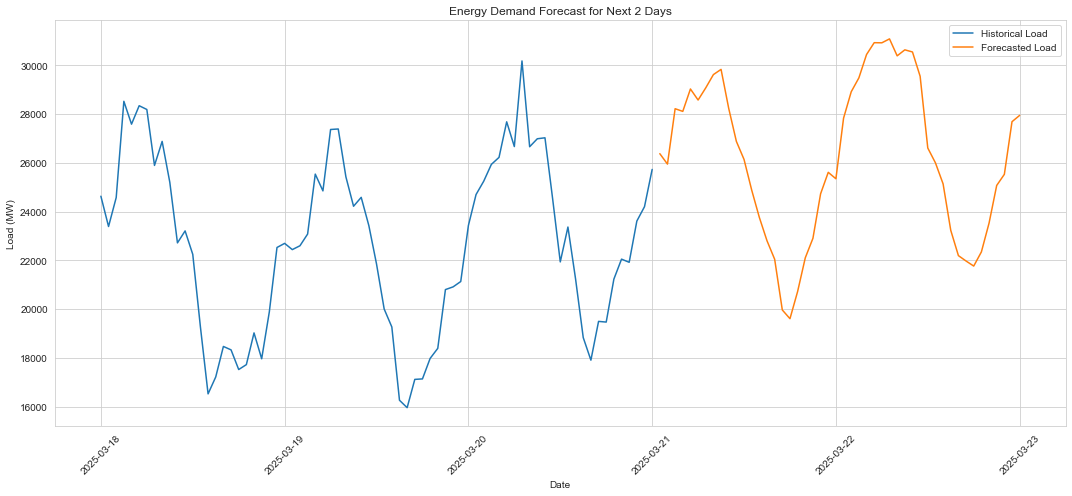

Forecast plot saved to data\load_forecast.png
Forecasting demand for the next 2 days...
Forecast plot saved to data\load_forecast.png


In [7]:
#!/usr/bin/env python3
# Dashboard for Energy Demand Forecasting System
# Author: Richard Kagame
# Date: March 22, 2025

import dash
from dash import dcc, html
import plotly.graph_objs as go
import plotly.express as px
from dash.dependencies import Input, Output
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from energy_forecaster import EnergyDemandForecaster


forecaster = EnergyDemandForecaster(data_dir="data")


end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')  # Yesterday
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')  # One year ago

# Check if the model exists, if not create it
model_path = os.path.join("data", "energy_forecast_model.pkl")
if not os.path.exists(model_path):
    # Preparing data
    data = forecaster.prepare_data(start_date, end_date)
    
    # Training model
    forecaster.train_model()
    
    # Saing model
    forecaster.save_model()
else:
    # Loading the model
    forecaster.load_model()
    

    data = forecaster.prepare_data(start_date, end_date)


forecast_days = 2
forecast = forecaster.forecast_next_days(days=forecast_days)


historical_data = forecaster.merged_data
historical_data = historical_data[['datetime', 'load_mw', 'temperature']].iloc[-7*24:]  # Last 7 days

# Initializing the Dash app
app = dash.Dash(__name__, title="Energy Demand Forecast Dashboard")


app.layout = html.Div([
    html.Div([
        html.H1("Energy Demand Forecasting Dashboard", 
                style={'textAlign': 'center', 'color': '#2c3e50', 'marginBottom': 20})
    ]),
    
    html.Div([
        html.Div([
            html.H3("Forecast Controls", style={'textAlign': 'center'}),
            html.Label("Select Forecast Horizon:"),
            dcc.Slider(
                id='forecast-days-slider',
                min=1,
                max=5,
                step=1,
                value=2,
                marks={i: f'{i} Days' for i in range(1, 6)}
            ),
            html.Div(id='slider-output-container', style={'margin-top': 20}),
            html.Button('Update Forecast', id='update-button', 
                       style={'backgroundColor': '#3498db', 'color': 'white', 
                              'padding': '10px 20px', 'border': 'none', 
                              'borderRadius': '5px', 'marginTop': '20px'}),
        ], style={'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
        
        html.Div([
            html.H3("Current Status", style={'textAlign': 'center'}),
            html.Div(id='current-status')
        ], style={'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px', 'marginTop': '20px'})
    ], style={'width': '25%', 'display': 'inline-block', 'verticalAlign': 'top', 'padding': '20px'}),
    
    html.Div([
        html.Div([
            html.H3("Energy Demand Forecast", style={'textAlign': 'center'}),
            dcc.Graph(id='forecast-graph')
        ], style={'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
        
        html.Div([
            html.Div([
                html.H3("Daily Peak Demand Forecast", style={'textAlign': 'center'}),
                dcc.Graph(id='peak-demand-graph')
            ], style={'width': '48%', 'display': 'inline-block', 'padding': '10px', 
                      'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
            
            html.Div([
                html.H3("Temperature vs. Demand", style={'textAlign': 'center'}),
                dcc.Graph(id='temp-demand-graph')
            ], style={'width': '48%', 'display': 'inline-block', 'padding': '10px', 
                      'backgroundColor': '#f8f9fa', 'borderRadius': '10px'})
        ], style={'display': 'flex', 'justifyContent': 'space-between', 'marginTop': '20px'})
    ], style={'width': '72%', 'display': 'inline-block', 'padding': '20px'})
])

@app.callback(
    Output('slider-output-container', 'children'),
    Input('forecast-days-slider', 'value')
)
def update_slider_output(value):
    return f'Selected forecast horizon: {value} days ({value*24} hours)'

@app.callback(
    [Output('forecast-graph', 'figure'),
     Output('peak-demand-graph', 'figure'),
     Output('temp-demand-graph', 'figure'),
     Output('current-status', 'children')],
    Input('update-button', 'n_clicks'),
    Input('forecast-days-slider', 'value')
)
def update_graphs(n_clicks, forecast_days):
    # new forecast with selected horizon
    forecast = forecaster.forecast_next_days(days=forecast_days)
    
    #forecast line graph
    fig1 = go.Figure()
    
    # Add historical data
    fig1.add_trace(go.Scatter(
        x=historical_data['datetime'],
        y=historical_data['load_mw'],
        mode='lines',
        name='Historical Demand',
        line=dict(color='#3498db', width=2)
    ))
    
    #forecast data
    fig1.add_trace(go.Scatter(
        x=forecast['datetime'],
        y=forecast['load_mw'],
        mode='lines',
        name='Forecasted Demand',
        line=dict(color='#e74c3c', width=2, dash='dash')
    ))
    

    current_time = datetime.now()
    fig1.add_shape(
        type="line",
        x0=current_time,
        y0=0,
        x1=current_time,
        y1=forecast['load_mw'].max() * 1.1,
        line=dict(color="green", width=2, dash="dashdot"),
    )
    
    fig1.add_annotation(
        x=current_time,
        y=forecast['load_mw'].max() * 1.05,
        text="Current Time",
        showarrow=True,
        arrowhead=1
    )
    
    fig1.update_layout(
        title='Energy Demand: Historical and Forecast',
        xaxis_title='Date & Time',
        yaxis_title='Load (MW)',
        template='plotly_white',
        height=400,
        margin=dict(l=20, r=20, t=40, b=20)
    )
    
 
    daily_forecast = forecast.copy()
    daily_forecast['date'] = daily_forecast['datetime'].dt.date
    daily_peak = daily_forecast.groupby('date')['load_mw'].max().reset_index()
    daily_peak['date_str'] = daily_peak['date'].astype(str)
    
    fig2 = go.Figure()
    fig2.add_trace(go.Bar(
        x=daily_peak['date_str'],
        y=daily_peak['load_mw'],
        marker_color='#9b59b6'
    ))
    
    fig2.update_layout(
        title='Daily Peak Demand Forecast',
        xaxis_title='Date',
        yaxis_title='Peak Load (MW)',
        template='plotly_white',
        height=300,
        margin=dict(l=20, r=20, t=40, b=20)
    )
    

    fig3 = px.scatter(
        historical_data, 
        x='temperature', 
        y='load_mw',
        color_discrete_sequence=['#2ecc71'],
        opacity=0.7,
        trendline='ols'
    )
    
    fig3.update_layout(
        title='Temperature vs. Energy Demand (Historical Data)',
        xaxis_title='Temperature',
        yaxis_title='Load (MW)',
        template='plotly_white',
        height=300,
        margin=dict(l=20, r=20, t=40, b=20)
    )
    
    # Create current status info
    current_forecast = forecast.iloc[0]
    next_hour_forecast = forecast.iloc[1]
    
    # Find today's peak
    today = datetime.now().date()
    today_forecast = forecast[forecast['datetime'].dt.date == today]
    
    if len(today_forecast) > 0:
        peak_load = today_forecast['load_mw'].max()
        peak_time = today_forecast.loc[today_forecast['load_mw'].idxmax(), 'datetime']
        peak_hour = peak_time.hour
    else:
        peak_load = "N/A"
        peak_hour = "N/A"
    
    status_info = html.Div([
        html.Div([
            html.H4("Current Hour Forecast:", style={'marginBottom': '5px'}),
            html.P(f"{current_forecast['load_mw']:.2f} MW", style={'fontSize': '24px', 'color': '#e74c3c'})
        ]),
        html.Div([
            html.H4("Next Hour Forecast:", style={'marginBottom': '5px'}),
            html.P(f"{next_hour_forecast['load_mw']:.2f} MW", style={'fontSize': '18px', 'color': '#3498db'})
        ]),
        html.Div([
            html.H4("Today's Peak Forecast:", style={'marginBottom': '5px'}),
            html.P(f"{peak_load if isinstance(peak_load, str) else peak_load:.2f} MW at hour {peak_hour}", 
                  style={'fontSize': '18px', 'color': '#9b59b6'})
        ]),
        html.Div([
            html.H4("Last Updated:", style={'marginBottom': '5px'}),
            html.P(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 
                  style={'fontSize': '14px', 'color': '#7f8c8d'})
        ])
    ])
    
    return fig1, fig2, fig3, status_info

if __name__ == '__main__':
  
    app.run(debug=True, port=8050)